# (Test Script) Single DFU Forecast

This is a test script for single DFU forecasts using the darts framework.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from darts import TimeSeries
from darts.metrics import mae, mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf, plot_hist
from darts.models import (
    ARIMA, AutoARIMA, NaiveEnsembleModel, ExponentialSmoothing, FFT, LightGBMModel, Prophet, RandomForest,
    RegressionModel, RegressionEnsembleModel
)

from input_handler import InputHandler
from darts_handler import DartsHandler
from forecast_metrics import fai_wts_dfu
from base import Config, loguru_logger, display_side_by_side

_logger = loguru_logger

pandarallel.initialize(progress_bar=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Script Settings

In [5]:
VALIDATION_SIZE = 0.3
FORECAST_HORIZON = 12
FAI_WEIGHTING_FACTORS = [0, 0.5, 0.3, 0.2]  # This is only for testing purposes, weighting factors should be DFU-specific

# Data Loading
---


In [3]:
sales_df = InputHandler.get_processed_data()


AttributeError: module 'base.loguru_logger' has no attribute 'info'

In [ ]:
sales_df.head()

,item_id,store_id,yearmonth,sales
0,FOODS_1_001,CA_1,2011-01-01,3
1,FOODS_1_001,CA_1,2011-02-01,40
2,FOODS_1_001,CA_1,2011-03-01,40
3,FOODS_1_001,CA_1,2011-04-01,23
4,FOODS_1_001,CA_1,2011-05-01,50


In [ ]:
# Number of DFUs and Stores:
print(f"Number of unique DFUs: {sales_df['item_id'].nunique()}")
print(f"Number of unique stores: {sales_df['store_id'].nunique()}")

Number of unique DFUs: 3049
Number of unique stores: 10


## Data Understanding

Things to check:
1. How much data (timestamps) do we have for each DFU?
2. What is the distribution of sales at a DFU-level, store-level?
3. Are there any seasonalities in the data at a month-level, or even across years?


In [16]:
# 1. How much data (timestamps) do we have for each DFU?
# FINDINGS: 
# It seems that all the DFU have equal duration of data (63 months).
# Based on this finding, it is worth considering to have a 70-30 split of data for training/validation testing.

def calc_month_diffs(dt1, dt2):
    return (dt2.year - dt1.year) * 12 + (dt2.month - dt1.month)


data_period_df = sales_df.groupby(['item_id', 'store_id'])\
    .apply(lambda x: (calc_month_diffs(x['yearmonth'].min(), x['yearmonth'].max())))\
    .reset_index(drop=False)\
    .rename(columns={0: 'Number of months'})

print("Distribution of number of months of data available across DFUs:")
print(data_period_df['Number of months'].value_counts())

Distribution of number of months of data available across DFUs:
63    30490
Name: Number of months, dtype: int64


In [17]:
# 2. What is the distribution of sales at DFU-level & store-level?
# FINDINGS:
# Total sales distribution at DFU-level is highly right-skewed, hence it is worth considering a log-normal transformation.
# Total sales distribution at store-level is not skewed, no transformation is required.
dfu_total_sales_df = sales_df.groupby(['item_id', 'store_id'])\
    .apply(lambda x: x['sales'].sum())\
    .reset_index(drop=False)\
    .rename(columns={0: 'Total Sales'})

store_total_sales_df = sales_df.groupby(['store_id'])\
    .apply(lambda x: x['sales'].sum())\
    .reset_index(drop=False)\
    .rename(columns={0: 'Total Sales'})

display_side_by_side([dfu_total_sales_df.head(), store_total_sales_df.head()], ['DFU-Level', 'Store-Level'])

/Users/winsonyeap/miniconda3/envs/sandbox/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/winsonyeap/miniconda3/envs/sandbox/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/var/folders/r9/18jz_4sx72x01pjrtpm3clqc0000gn/T/ipykernel_49209/3067234823.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


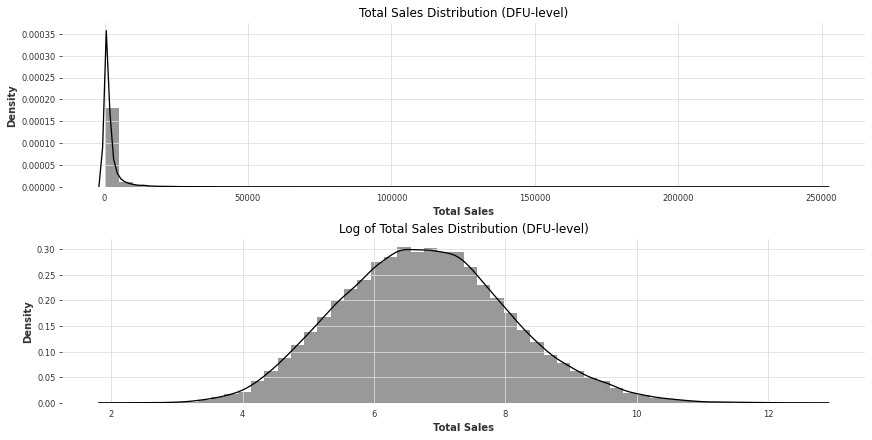

In [18]:
# DFU-Level Histogram
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), constrained_layout=True)
sns.distplot(dfu_total_sales_df['Total Sales'], ax=axes[0])
sns.distplot(np.log(dfu_total_sales_df['Total Sales']), ax=axes[1])
axes[0].set_title("Total Sales Distribution (DFU-level)")
axes[1].set_title("Log of Total Sales Distribution (DFU-level)")
fig.show()

/Users/winsonyeap/miniconda3/envs/sandbox/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/winsonyeap/miniconda3/envs/sandbox/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/var/folders/r9/18jz_4sx72x01pjrtpm3clqc0000gn/T/ipykernel_49209/2635394754.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


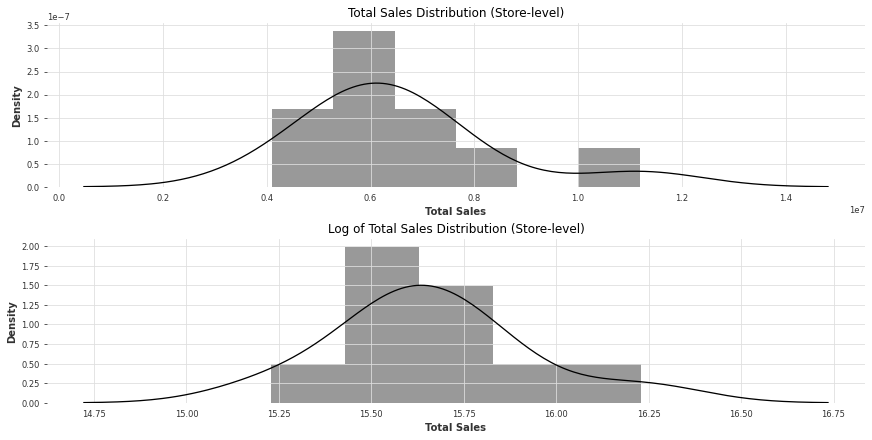

In [19]:
# Store-Level Histogram
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), constrained_layout=True)
sns.distplot(store_total_sales_df['Total Sales'], ax=axes[0])
sns.distplot(np.log(store_total_sales_df['Total Sales']), ax=axes[1])
axes[0].set_title("Total Sales Distribution (Store-level)")
axes[1].set_title("Log of Total Sales Distribution (Store-level)")
fig.show()

/var/folders/r9/18jz_4sx72x01pjrtpm3clqc0000gn/T/ipykernel_49209/2059774017.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


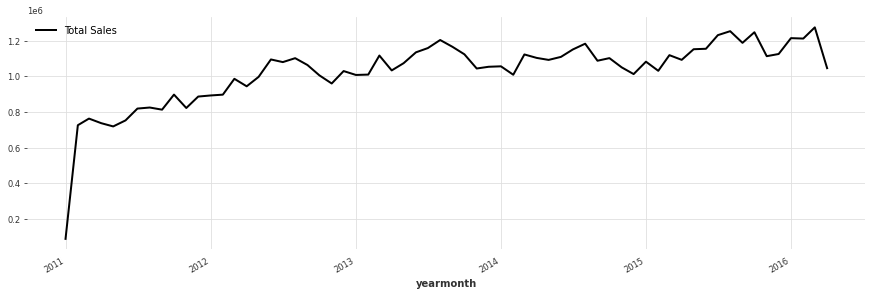

In [20]:
# 3. Are there any seasonalities in the data at a month-level, or even across years?
# FINDINGS:
# Seasonality at an overall level shows that seasonality is at a 10-month cycle. However, it makes more sense to use a
# 12-cycle seasonality.

# Let's take a look at overall level
overall_sales_df = sales_df.groupby(['yearmonth'])\
    .apply(lambda x: x['sales'].sum())\
    .reset_index(drop=False)\
    .rename(columns={0: 'Total Sales'})

overall_sales_ts = TimeSeries.from_dataframe(overall_sales_df, 'yearmonth', 'Total Sales')

fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
overall_sales_ts.plot(ax=ax)
fig.show()

Seasonality check: (True, 10)


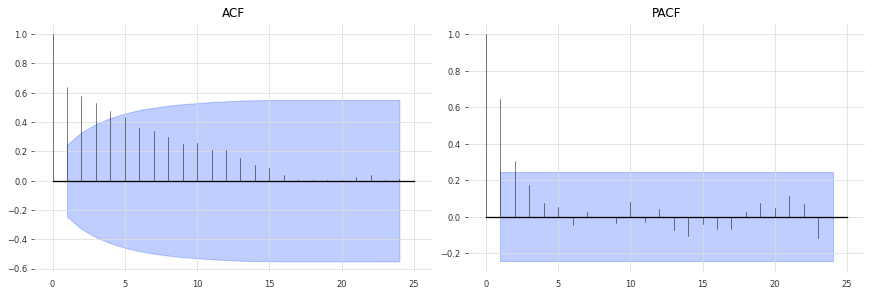

In [21]:
# Checking for seasonality
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), constrained_layout=True)
plot_acf(overall_sales_ts, axis=axes[0])
plot_pacf(overall_sales_ts, axis=axes[1])
axes[0].set_title("ACF")
axes[1].set_title("PACF")

print(f"Seasonality check: {check_seasonality(overall_sales_ts, max_lag=24)}")

In [43]:
# Checking seasonality at a DFU-level, consolidating the seasonalities detected for each DFU and plotting them in a 
# histogram to find a common/generic seasonality cycle
def check_seasonality_dfu_level(dfu_df):
    """Sub-function for checking seasonality for each DFU subgroup."""
    dfu_df = dfu_df.copy().reset_index(drop=False)
    dfu_ts = TimeSeries.from_dataframe(dfu_df, 'yearmonth', 'sales')
    seasonality_results = check_seasonality(dfu_ts, max_lag=24)
    return seasonality_results


dfu_seasonality_df = sales_df.groupby(['item_id', 'store_id'])\
    .parallel_apply(lambda x: check_seasonality_dfu_level(x))\
    .reset_index(drop=False)\
    .rename(columns={0: 'Seasonality'})

dfu_seasonality_df['Seasonality Detected'] = dfu_seasonality_df['Seasonality'].apply(lambda x: x[0])
dfu_seasonality_df['Seasonality (Cycles)'] = dfu_seasonality_df['Seasonality'].apply(lambda x: x[1])


[2022-01-10 09:21:23,963] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:23.967 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:23,970] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:23.973 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:23,991] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:23.993 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,027] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.029 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,043] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.045 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,055] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.057 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,132] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.134 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,236] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.238 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,260] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.264 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,271] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.273 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,302] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.304 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,322] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.324 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,350] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.352 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,479] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.482 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,492] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.494 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,507] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.509 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,524] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:24,525] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.528 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:24.531 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,545] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.548 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,558] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.561 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,586] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.592 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,626] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:24,626] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.636 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:24.637 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,668] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:24,670] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.670 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:24.673 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,684] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.688 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,700] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:24,701] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.703 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:24.703 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,716] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.718 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,725] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.730 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,766] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.769 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,787] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:24,788] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.789 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:24.790 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,806] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.812 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,865] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.868 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,882] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.886 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,889] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.892 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,914] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:24,914] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.917 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:24.917 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,930] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.933 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,945] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.949 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,957] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.959 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,961] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.965 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,972] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.975 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:24,987] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:24.990 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,008] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.011 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,024] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:25,025] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.027 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:25.027 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,079] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.082 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,115] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.118 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,191] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.202 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,208] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.211 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,225] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.229 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,310] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.314 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,397] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.404 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,411] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.416 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,421] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.424 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,460] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.464 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,494] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.500 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,564] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.566 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,589] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.591 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,604] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.608 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,635] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.638 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,659] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.662 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,676] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.679 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,677] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.686 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,725] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.728 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,767] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.770 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,793] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.795 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,818] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.821 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,835] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:25,835] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.837 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:25.844 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,857] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:25,859] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.861 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:25.862 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,877] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.879 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,889] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.892 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,905] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.921 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,936] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.938 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,946] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.948 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,953] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.956 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,964] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:25,961] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.967 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,971] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.973 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:25.974 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,985] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.990 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:25,993] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:25.995 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,008] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.015 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,028] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.031 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,038] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.040 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,085] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.089 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,195] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.202 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,228] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.231 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,243] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.247 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,273] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.276 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,330] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.333 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,355] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.357 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,381] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.384 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,409] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.415 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,423] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.425 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,473] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.478 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,484] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:26,487] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.488 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:26.491 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,513] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.517 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,531] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.533 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,532] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.549 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,555] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.559 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,576] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.586 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,584] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.591 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,600] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.603 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,617] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:26,616] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.620 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:26.622 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,635] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.641 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,654] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.660 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,665] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.670 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,683] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.686 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,702] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.716 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,729] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.731 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,742] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.745 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,777] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.783 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,808] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.810 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,824] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.848 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,871] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:26,881] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.886 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:26.890 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,906] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.923 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,926] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.948 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,952] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.955 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,972] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.982 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:26,988] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:26,992] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:26.991 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:26.994 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,032] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.035 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,053] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.057 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,062] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.074 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,088] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.098 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,103] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.105 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,126] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:27,133] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.133 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:27.136 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,188] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.191 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,217] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.220 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,251] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.254 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,310] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.313 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,382] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.387 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,432] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.435 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,503] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.506 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,574] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.577 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,568] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.582 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,632] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.635 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,651] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.654 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,667] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:27,674] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.677 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:27.676 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,693] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.696 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,698] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.702 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,707] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.710 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,713] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.719 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,731] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.736 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,868] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.879 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,949] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:27,952] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.953 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:27.955 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:27,955] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:27.970 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,022] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.029 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,055] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.058 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,070] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.073 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,112] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.116 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,120] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:28,118] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.124 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,134] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.126 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,137] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.138 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:28.140 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,153] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.162 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,186] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.188 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,207] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.213 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,217] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.219 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,230] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.233 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,256] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.259 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,298] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.301 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,314] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.325 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,342] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.347 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,363] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.373 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,388] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.395 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,386] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.402 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,413] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.416 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,429] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.431 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,443] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.447 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,450] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.453 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,455] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:28,459] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.457 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:28.461 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,472] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.480 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,493] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.497 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,510] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.513 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,518] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.520 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,540] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:28,541] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.543 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,534] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.545 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:28.550 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,561] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.568 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,574] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.576 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,589] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.592 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,581] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.607 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,605] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:28,622] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.628 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:28.630 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,649] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.655 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,643] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.664 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,671] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.677 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,692] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.697 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,706] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.708 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,712] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.718 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,734] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:28,735] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.736 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:28.741 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,756] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.759 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,767] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:28,771] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:28,773] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.773 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:28.774 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:28.776 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,788] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.793 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,803] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:28,806] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.808 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,812] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.816 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:28.813 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,836] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:28,837] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.844 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:28.845 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,867] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.880 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,901] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:28,902] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.907 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,922] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.908 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,921] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.936 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:28.938 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,943] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.946 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,977] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.980 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:28,991] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:28.995 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,009] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.012 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,023] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.032 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,035] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.038 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,052] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.068 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,089] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.091 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,104] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.142 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,161] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.197 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,277] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:29,250] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.301 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,309] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.304 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:29.318 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,343] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.346 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,352] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.354 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,369] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.373 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,388] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:29,388] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.390 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,392] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.394 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:29.397 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,417] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.420 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,425] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:29,418] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.427 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:29.428 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,440] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.458 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,480] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.483 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,504] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.510 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,514] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.517 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,567] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.576 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,589] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.592 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,605] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.608 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,629] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:29,632] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.633 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:29.635 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,661] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.663 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,676] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.686 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,716] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.720 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,724] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.729 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,738] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.741 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,770] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.774 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,787] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.797 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,818] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.821 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,837] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:29,836] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.840 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:29.842 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,860] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.865 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:29,983] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:29.989 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,000] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.002 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,003] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.009 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,022] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:30,017] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.027 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:30.030 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,042] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.045 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,047] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.053 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,074] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.077 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,090] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.092 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,107] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.124 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,134] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:30,129] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.141 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:30.141 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,200] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.204 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,277] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.285 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,289] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.291 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,299] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.302 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,309] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:30,314] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.315 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:30.316 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,355] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:30,354] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.358 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:30.358 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,394] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.397 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,429] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.433 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,441] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.454 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,457] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.459 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,515] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.519 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,536] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.542 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,540] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.546 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,559] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.563 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,586] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.589 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,611] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.624 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,649] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.652 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,692] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:30,695] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.697 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:30.700 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,722] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.725 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,790] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.793 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,874] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.876 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,877] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.886 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,921] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.923 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,938] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.947 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,969] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.971 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:30,992] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:30.997 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,025] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.031 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,043] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.046 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,086] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.088 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,087] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.100 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,169] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.172 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,238] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,237] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.240 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.240 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,252] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.254 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,260] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.263 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,275] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.277 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,296] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.299 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,308] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.311 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,313] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.316 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,325] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,324] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,330] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.332 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.333 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.335 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,346] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,349] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.350 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.351 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,348] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,356] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.359 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.361 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,364] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.368 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,381] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,382] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,382] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.384 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.384 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.385 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,400] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.406 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,412] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.414 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,420] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.429 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,449] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.456 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,469] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.476 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,487] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.491 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,545] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,550] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.548 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.552 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,562] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.564 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,566] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.569 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,576] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,587] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.588 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.590 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,601] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.605 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,612] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,612] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.614 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.617 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,630] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.633 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,646] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.651 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,666] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.668 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,681] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.684 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,699] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.706 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,716] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.720 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,742] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.746 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,787] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.789 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,802] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,803] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.804 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.807 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,821] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.829 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,831] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.833 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,844] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.847 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,861] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.879 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,907] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.912 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,924] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:31,924] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.927 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:31.927 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,939] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.942 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,965] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.968 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,982] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.986 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:31,991] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:31.994 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,002] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.005 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,018] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.026 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,039] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:32,040] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.042 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:32.047 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,056] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:32,059] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.060 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:32.062 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,074] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.083 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,085] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.088 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,164] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.172 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,193] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.196 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,200] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.205 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,228] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.233 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,247] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.254 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,267] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:32,275] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.276 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:32.277 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,290] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.293 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,351] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.355 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,371] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:32,372] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.374 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:32.381 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,396] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.401 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,419] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:32,421] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.425 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:32.426 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,445] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.448 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,474] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.477 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,502] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.505 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,506] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.508 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,521] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:32,520] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.523 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:32.525 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,536] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.546 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,567] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.571 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,584] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.594 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,609] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.621 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,633] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.637 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,646] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:32,649] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.649 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:32.651 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,668] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.671 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,673] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.675 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,696] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.699 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,706] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.709 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,722] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.725 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,731] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:32,731] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.733 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,735] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.737 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:32.738 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,751] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.763 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,769] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.773 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,785] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:32,783] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.788 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:32.790 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,800] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.808 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,823] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.832 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,856] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.859 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,873] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.880 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,902] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.905 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,962] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.966 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:32,995] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:32.998 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,010] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.013 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,013] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,013] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.017 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,018] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.017 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.020 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,031] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.033 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,046] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.049 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,059] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.062 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,062] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,088] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.087 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.091 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,085] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,100] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.101 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.103 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,128] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,129] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,130] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.130 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.132 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.132 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,144] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.149 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,163] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.170 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,177] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.189 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,204] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,212] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.212 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.216 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,226] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.230 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,247] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.250 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,259] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.262 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,294] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,296] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.299 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.303 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,312] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,316] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.318 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.321 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,331] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,335] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.337 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.337 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,352] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,360] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.358 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.362 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,377] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.382 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,388] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.396 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,398] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.400 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,409] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.411 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,431] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,434] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.436 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.438 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,452] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.458 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,470] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.473 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,495] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.498 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,554] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,549] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.562 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,560] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.564 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.567 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,576] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.583 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,587] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.590 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,630] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.633 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,680] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,683] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,684] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.686 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.685 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.687 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,689] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,700] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.700 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.703 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,747] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.750 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,758] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.766 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,802] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,802] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.806 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,808] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.806 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.812 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,818] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,822] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.823 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.824 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,839] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,847] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.849 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.850 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,864] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.868 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,883] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.889 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,895] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.897 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,913] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.915 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,910] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.927 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,928] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,940] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.942 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.946 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,955] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.960 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,962] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.965 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,972] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.975 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:33,985] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:33,988] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:33.989 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:33.990 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,001] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.003 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,011] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:34,015] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.014 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:34.018 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,030] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.040 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,048] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.051 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,053] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.055 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,053] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.063 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,067] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.076 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,125] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.129 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,177] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.181 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,263] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.273 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,285] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.289 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,304] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.307 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,307] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.313 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,317] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:34,320] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.319 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:34.322 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,326] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.329 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,334] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:34,340] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.340 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:34.344 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,352] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.355 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,356] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.362 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,358] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.371 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,368] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:34,376] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.379 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:34.383 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,392] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.395 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,396] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.399 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,446] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.450 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,463] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.466 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,501] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.506 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,542] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.545 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,562] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:34,562] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.564 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:34.565 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,579] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.584 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,600] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.605 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,612] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.616 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,653] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.656 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,688] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.699 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,753] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:34,758] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.760 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:34.763 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,770] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.782 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,825] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.832 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,840] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.846 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,849] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.857 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,871] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.875 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,873] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.881 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,898] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.903 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,906] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.918 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,922] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.929 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,941] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.944 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,974] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:34.982 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:34,997] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.001 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,009] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.017 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,026] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.029 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,032] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.039 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:35.035 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,031] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:35,048] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.057 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,069] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.072 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,104] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.108 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,121] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.130 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,142] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.145 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,151] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.155 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,166] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.169 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,176] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.179 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,192] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:35,195] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.195 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:35.197 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,222] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.225 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,249] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.254 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,254] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.259 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,273] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.277 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,286] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.288 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,311] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.322 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,390] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.394 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,403] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.407 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,417] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.419 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,418] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.427 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,430] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.433 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,440] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.443 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,448] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.452 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,577] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.581 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,610] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.613 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,620] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.624 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,639] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.641 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,654] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.656 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,670] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.674 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,716] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.721 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,734] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.739 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,768] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:35,772] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.775 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:35.771 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,806] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.810 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,823] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.826 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,818] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.831 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,862] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.870 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,894] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.899 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,914] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.918 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,935] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:35,944] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.947 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:35.948 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:35,981] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:35.984 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,005] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.009 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,011] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.020 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,022] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.028 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,044] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.048 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,077] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.080 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,121] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.128 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,154] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.157 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,270] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.273 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,302] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.305 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,321] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.325 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,352] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:36,352] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.354 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:36.358 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,372] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:36,379] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.378 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:36.382 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,394] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:36,402] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.398 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,402] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.406 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:36.406 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,397] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.419 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,423] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.426 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,439] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.441 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,448] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.450 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,463] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:36,470] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.469 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:36.472 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,484] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.488 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,512] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:36,514] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.516 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:36.517 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,533] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:36,536] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:36,536] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.537 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:36.539 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:36.541 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,576] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.579 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,592] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.603 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,611] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.614 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,632] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.634 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,640] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.654 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,691] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.695 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,702] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.714 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,719] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.722 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,746] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.751 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,763] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.774 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,795] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.799 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,820] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.823 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,848] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.852 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,930] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.934 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,953] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.956 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:36,950] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:36.961 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,000] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.003 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,017] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.032 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,036] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.048 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,056] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,049] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.059 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.063 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,180] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.182 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,198] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.214 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,251] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.258 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,278] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.283 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,292] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,297] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.296 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.300 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,379] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.382 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,394] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.413 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,432] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.440 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,462] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.473 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,484] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.490 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,500] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.504 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,524] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,521] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.528 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.532 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,557] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.560 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,571] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.581 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,593] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.595 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,614] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,609] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.616 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.620 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,634] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.636 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,650] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.652 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,669] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.671 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,703] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,702] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.706 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.711 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,715] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.724 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,773] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.776 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,817] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.823 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,830] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,834] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.833 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.836 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,857] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.860 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,866] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,866] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.868 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,869] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.874 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.877 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,884] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,888] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.888 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.891 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,895] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,896] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.899 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,902] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.900 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.906 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,933] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,935] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.938 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.945 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,959] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,962] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.963 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.966 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:37,978] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,982] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:37,982] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:37.984 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.987 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:37.988 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,002] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,001] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.004 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.004 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,013] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.016 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,035] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.038 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,050] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,050] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.052 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.053 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,070] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,065] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.073 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.077 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,086] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.092 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,091] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.102 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,106] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.116 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,130] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,131] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.135 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.139 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,145] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.149 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,150] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.155 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,169] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,169] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.172 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.172 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,187] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.189 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,252] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.260 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,300] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,306] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.307 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.309 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,322] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.325 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,330] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.332 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,337] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.349 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,365] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.368 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,395] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.399 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,426] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.429 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,431] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.433 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,446] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,456] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.457 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.462 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,474] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,485] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,486] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.486 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.489 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.489 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,503] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.507 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,520] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.523 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,540] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,546] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.545 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.549 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,712] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.723 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,736] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.739 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,759] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.761 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,790] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.794 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,841] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.845 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,859] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.868 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,871] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.874 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,891] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.895 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,896] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,901] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.901 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.908 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,909] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.919 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,933] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.939 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,954] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.956 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,952] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.964 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,970] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.973 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:38,984] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:38,987] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:38.990 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:38.995 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,012] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,016] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.016 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.020 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,044] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,044] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.047 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.052 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,068] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.070 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,106] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,109] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.109 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.112 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,136] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.139 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,161] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.165 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,174] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.179 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,180] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.191 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,206] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.209 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,220] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.231 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,235] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.244 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,266] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,266] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.269 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.269 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,274] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.280 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,298] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,302] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,302] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.301 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.304 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.306 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,312] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.316 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,318] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,322] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,329] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.330 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.331 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.334 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,358] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,355] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.361 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.361 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,381] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.384 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,431] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.434 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,459] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,469] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,472] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.474 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.473 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.476 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,492] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,494] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.494 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.498 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,605] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.610 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,581] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.622 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,651] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,676] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.714 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.714 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,736] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.741 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,760] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.766 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,779] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.782 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,801] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,797] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,805] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.806 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.807 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.807 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,823] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,831] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.833 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.834 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,835] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,848] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.848 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.850 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,882] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.890 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,903] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.906 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,905] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.912 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,920] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.923 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,936] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:39,945] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.948 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:39.949 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,962] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.967 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,964] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:39.982 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:39,996] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.002 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,014] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.017 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,027] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.029 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,030] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.046 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,050] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.052 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,049] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,062] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.061 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.066 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,080] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,086] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.089 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.089 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,100] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.103 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,107] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,109] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,109] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.112 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.113 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.115 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,127] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,127] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.131 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.132 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,170] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.174 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,185] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.192 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,244] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.255 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,260] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.263 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,268] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.275 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,317] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,320] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.324 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.325 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,338] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.352 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,357] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.363 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,367] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,360] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.369 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,367] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.375 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.377 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,383] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,389] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.391 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.395 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,402] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,401] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.405 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.406 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,411] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,407] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.413 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.417 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,425] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,427] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.428 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,432] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,432] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.432 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.434 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.437 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,434] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,441] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.447 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,450] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.448 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.454 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,465] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:40,468] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.473 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:40.473 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,487] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.494 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,509] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.513 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,516] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.519 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,532] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.539 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,554] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.559 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,606] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.609 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,627] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.632 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,636] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.646 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,647] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.655 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,669] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.671 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,708] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.711 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,788] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.815 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,849] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.858 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,871] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.873 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,887] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.915 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,940] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.946 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:40,962] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:40.967 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,007] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.010 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,061] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.066 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,107] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.124 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,134] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.138 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,140] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.144 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,230] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.233 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,227] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.242 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,289] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.292 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,297] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:41,301] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.302 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:41.305 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,315] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.325 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,339] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.344 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,377] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.381 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,396] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.407 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,426] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:41,430] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.436 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:41.437 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,453] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.462 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,479] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.481 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,479] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.493 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,506] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.509 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,540] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.546 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,560] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.563 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,605] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.610 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,735] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.741 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,776] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:41,778] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.780 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:41.780 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,808] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.812 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,833] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.840 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,874] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.876 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,923] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.925 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,971] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.974 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:41,988] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:41.990 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,001] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.004 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,014] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:42,022] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.023 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:42.026 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,043] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:42,046] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.045 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:42.049 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,059] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.070 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,149] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:42,157] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:42,173] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.167 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:42.177 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,195] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.187 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:42.201 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,230] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.234 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,254] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.263 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,298] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.302 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,325] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.328 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,355] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.358 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,380] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.390 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,418] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:42,416] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.424 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:42.426 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,439] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.448 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,466] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.471 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,488] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.490 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,516] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.525 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,575] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.580 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,587] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.593 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,623] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.626 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,640] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.647 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,669] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.672 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,682] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.688 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,688] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.699 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,712] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.715 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,717] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.724 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,761] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.766 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,804] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:42,802] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.813 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:42.814 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,861] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.870 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,894] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.896 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:42,926] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:42,930] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:42.929 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:42.933 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,067] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.083 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,098] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.110 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,148] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.153 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,249] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.263 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,299] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.302 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,306] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.311 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,325] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:43,329] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:43,328] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.332 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:43.334 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:43.335 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,357] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.362 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,380] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:43,385] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:43,388] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.388 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:43.390 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:43.392 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,403] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:43,406] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.416 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:43.415 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,418] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.430 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,433] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.436 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,437] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:43,446] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.447 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,450] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.450 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:43.452 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,470] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.476 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,490] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.493 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,498] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.503 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,549] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.552 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,560] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:43,564] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.565 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:43.567 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,629] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.671 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,737] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.760 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,782] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.785 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,804] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.811 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,856] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:43,856] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.859 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:43.860 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,888] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.899 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,957] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.960 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:43,976] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:43,978] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:43.981 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:43.982 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,019] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.025 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,037] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.040 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,054] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.057 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,072] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.076 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,089] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.093 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,172] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.179 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,186] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.192 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,202] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,203] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,207] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.206 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.208 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,206] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.210 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.216 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,232] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,235] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.236 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.238 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,239] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.246 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,252] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,263] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.265 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.267 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,281] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.285 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,299] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,304] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.305 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.309 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,321] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,323] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.330 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.331 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,349] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,351] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.362 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.370 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,382] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,390] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,389] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,391] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.391 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.397 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,403] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.398 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.397 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,417] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.410 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,421] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,430] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.423 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.431 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,438] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.436 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,450] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.445 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.459 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,486] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.489 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,511] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,516] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.514 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.519 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,586] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.602 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,667] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.669 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,674] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,681] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.684 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.683 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,785] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.795 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,810] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,811] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.814 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.815 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,831] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.835 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,866] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.870 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,882] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.885 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,885] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:44,888] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.898 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:44.898 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,926] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.928 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,938] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.941 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:44,958] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:44.961 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,001] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.005 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,024] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.029 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,057] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.067 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,068] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.077 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,083] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.085 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,103] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.114 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,138] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:45,143] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.141 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:45.146 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,156] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:45,166] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.166 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:45.170 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,184] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.194 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,216] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:45,214] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.219 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:45.219 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,246] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.249 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,448] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.457 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,571] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.584 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,612] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.624 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,658] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.663 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,676] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.680 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,684] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.690 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,703] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.708 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,719] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.724 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,781] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.783 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,806] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.811 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,823] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.831 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,855] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.861 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,867] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.870 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,871] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.878 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,885] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:45,890] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.898 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:45.902 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,936] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.939 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,949] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:45,955] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:45.955 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:45.959 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:45,997] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.008 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,034] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.038 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,054] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.060 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,076] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.080 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,094] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.097 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,108] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:46,112] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.118 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,121] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.118 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:46.125 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,146] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.149 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,157] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.160 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,168] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.176 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,174] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.192 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,198] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:46,195] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.200 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:46.207 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,226] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.229 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,243] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.246 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,261] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:46,265] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.268 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:46.269 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,284] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.287 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,296] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.299 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,300] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.309 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,315] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.318 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,326] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.329 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,331] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:46,334] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.336 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:46.338 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,357] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.360 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,355] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.366 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,388] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.391 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,404] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.412 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,430] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.442 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,465] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.468 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,458] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.478 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,483] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.494 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,507] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:46,511] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.511 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:46.514 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,528] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:46,532] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.534 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:46.536 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,550] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.553 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,551] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.560 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,571] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.574 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,587] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.594 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,607] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.609 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,608] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.622 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,634] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:46,636] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.636 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:46.639 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,647] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:46,650] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.652 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:46.655 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,665] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.670 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,682] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.688 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,695] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.698 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,700] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.703 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,729] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.733 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,757] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.761 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,794] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.798 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,807] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.810 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,827] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.833 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:46,960] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:46,995] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:46.997 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:46.999 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,015] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.021 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,051] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.055 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,074] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.078 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,092] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,097] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,103] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.101 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.101 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.105 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,127] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.134 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,144] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.148 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,173] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.176 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,186] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.188 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,213] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.216 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,226] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,232] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.236 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.238 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,255] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.258 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,265] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.272 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,272] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.279 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,296] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,299] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.300 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.305 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,318] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.322 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,332] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.338 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,358] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,367] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.367 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.372 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,378] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,384] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.383 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.387 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,399] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.407 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,413] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.416 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,432] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.435 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,441] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.444 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,454] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.459 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,468] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.476 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,470] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.485 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,489] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,490] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.497 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.498 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,501] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.512 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,525] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,524] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.528 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,530] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.528 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.535 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,545] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,552] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.555 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.560 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,567] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.570 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,571] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.584 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,587] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.593 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,602] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.605 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,621] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.624 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,648] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,648] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,649] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.651 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,653] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.651 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.654 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.657 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,677] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.682 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,701] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.703 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,707] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.712 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,715] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.719 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,718] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.735 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,735] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.751 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,765] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.768 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,791] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.795 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,881] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.884 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,905] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.909 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,922] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.930 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,947] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,947] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.950 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:47.950 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,963] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:47.969 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:47,989] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:47,997] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.000 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:48.000 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,012] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:48,013] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.016 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:48.016 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,031] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:48,031] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.038 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,044] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.038 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:48.047 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,093] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.100 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,130] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.134 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,246] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.249 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,256] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.262 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,272] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.279 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,301] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.306 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,446] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.452 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,466] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.479 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,491] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.496 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,499] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.502 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,516] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:48,531] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.534 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:48.536 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,593] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.598 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,612] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.625 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,636] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:48,640] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.640 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:48.643 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,666] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.669 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,749] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.752 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,801] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.808 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,919] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.933 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,950] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.959 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,966] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.971 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:48,996] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:48,996] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:48.998 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:48.999 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,013] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.025 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,029] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.037 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,040] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.042 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,051] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.058 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,091] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.095 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,114] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.122 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,199] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.203 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,230] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.243 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,259] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.262 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,275] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.291 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,306] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.309 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,324] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.329 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,343] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.347 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,370] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.373 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,368] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.380 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,389] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.400 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,414] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.421 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,452] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.456 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,456] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.468 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,501] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:49,502] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.504 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:49.504 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,548] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.570 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,623] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:49,623] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.626 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,629] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:49,629] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.631 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:49.631 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:49.634 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,640] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.660 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,660] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.666 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,673] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.676 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,685] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.688 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,709] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.724 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,739] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.744 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,763] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:49,760] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.766 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:49.770 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,798] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:49,792] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.802 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:49.804 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,808] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.814 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,829] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.842 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,850] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:49,853] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.854 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:49.856 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,863] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:49,867] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:49,873] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.872 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:49.871 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:49.876 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,893] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.908 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,915] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.919 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,953] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.956 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,958] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:49.970 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:49,984] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:50,001] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.014 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,058] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.054 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:50.081 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,122] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:50,125] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.124 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:50.129 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,138] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.141 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,154] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.158 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,164] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.179 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,189] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.192 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,258] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.261 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,280] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.283 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,281] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.288 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,302] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.308 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,312] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.314 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,341] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.347 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,360] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.363 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,374] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.399 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,415] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.418 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,419] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:50,425] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.427 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:50.436 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,454] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.459 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,475] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.478 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,578] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.582 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,628] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.631 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,657] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:50,658] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.661 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,665] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.664 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:50.669 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,677] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.681 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,703] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.709 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,701] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.714 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,733] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.736 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,745] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:50,736] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.748 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:50.752 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,750] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.756 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,768] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.771 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,784] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.794 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,845] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.849 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,854] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.862 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,903] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:50,904] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.909 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:50.912 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,936] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.961 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,967] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.978 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:50,981] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:50.990 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,003] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,005] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.006 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.008 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,019] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,022] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.023 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.025 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,037] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.041 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,064] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.071 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,107] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,110] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.110 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.113 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,135] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.146 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,160] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.172 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,195] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,183] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.198 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.201 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,214] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.220 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,234] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,245] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.249 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.248 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,270] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,268] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.276 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.277 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,285] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.288 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,312] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.317 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,368] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.376 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,405] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.413 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,444] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.450 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,454] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.463 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,466] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.468 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,483] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,477] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.491 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.491 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,497] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.500 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,509] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,509] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.513 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.516 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,531] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,532] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.534 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.535 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,538] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.542 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,550] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.553 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,557] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.566 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,576] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.579 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,583] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.594 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,593] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.606 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,629] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.632 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,640] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.644 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,651] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.653 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,660] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.668 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,667] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.680 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,686] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.693 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,707] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.711 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,732] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,736] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.734 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.738 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,784] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,789] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.792 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.792 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,809] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.821 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,835] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.838 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,860] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.862 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,865] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.877 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,896] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.900 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,934] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.938 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,947] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.953 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,972] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.974 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,975] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,978] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:51,973] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:51.980 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.982 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:51.985 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,996] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.002 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:51,999] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.012 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,026] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.029 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,035] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.044 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,054] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.057 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,071] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.079 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,098] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.101 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,105] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.107 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,117] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:52,104] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.121 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:52.126 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,164] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.166 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,187] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.190 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,202] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.207 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,213] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.215 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,229] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.233 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,249] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.255 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,260] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.262 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,276] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.293 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,306] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:52,308] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.309 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:52.313 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,321] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.330 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,359] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.361 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,389] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.392 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,398] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.403 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,405] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:52,419] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.418 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:52.422 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,434] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:52,435] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.436 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:52.438 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,454] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.457 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,468] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.471 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,477] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.485 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,501] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:52,501] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.506 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:52.506 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,518] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.521 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,524] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.533 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,521] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.545 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,555] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:52,549] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:52,564] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.562 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:52.563 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:52.567 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,581] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:52,585] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.590 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:52.592 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,605] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.608 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,613] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.616 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,623] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.627 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,662] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.667 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,684] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.691 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,698] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.701 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,728] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.733 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,747] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.752 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,777] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.781 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,792] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.794 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,799] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.802 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,813] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.816 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,852] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.856 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,864] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.867 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,925] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.928 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,960] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.964 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:52,986] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:52.989 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,005] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,007] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.011 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,013] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.014 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.018 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,033] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.038 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,047] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.052 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,053] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.061 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,076] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.078 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,092] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.097 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,111] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.114 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,119] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.121 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,129] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.135 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,136] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,135] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,141] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.141 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.145 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.145 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,150] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.160 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,162] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,166] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.170 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.170 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,184] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,184] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,186] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.186 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.189 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.197 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,202] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.212 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,212] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.227 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,248] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.251 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,259] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.262 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,268] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.273 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,288] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.297 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,374] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.384 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,419] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.423 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,431] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.436 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,440] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.443 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,451] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,456] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.457 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.459 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,473] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,479] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.482 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.487 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,492] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,503] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.494 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.509 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,523] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.526 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,539] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,544] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.546 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,546] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.545 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.551 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,569] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,570] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.574 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.576 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,589] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.600 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,684] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.692 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,695] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.700 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,712] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.716 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,715] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.726 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,732] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,740] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.739 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.743 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,748] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.753 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,752] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,764] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.766 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.768 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,782] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.784 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,806] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.809 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,819] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,819] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.822 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.824 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,822] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.836 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,847] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:53,849] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.852 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:53.854 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,852] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.865 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,883] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.886 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,882] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.894 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,903] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.924 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:53,935] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:53.940 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,042] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.046 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,040] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.075 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,061] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:54,106] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.100 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:54.123 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,133] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.138 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,209] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.214 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,256] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.265 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,282] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.286 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,302] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.306 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,316] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.319 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,333] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.346 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,363] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.366 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,384] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.388 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,406] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:54,415] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.417 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:54.418 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,442] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.446 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,463] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.466 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,477] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.483 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,538] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.541 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,555] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.558 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,568] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.574 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,601] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.616 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,631] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.634 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,700] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.702 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,749] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.759 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,767] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.775 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,773] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.795 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,797] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.809 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,826] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:54,832] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.839 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:54.841 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,881] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:54,883] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:54,887] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.886 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:54.890 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:54.891 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,911] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.914 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:54,955] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:54.958 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,057] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.060 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,113] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.116 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,391] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.396 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,412] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.419 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,427] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:55,424] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.435 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:55.435 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,470] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.474 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,497] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:55,493] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.501 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:55.503 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,525] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.528 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,539] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.542 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,549] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.552 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,581] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.584 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,613] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:55,612] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.623 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,626] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.624 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:55.640 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,643] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.645 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,669] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:55,670] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.674 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:55.674 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,690] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:55,691] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.694 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:55.694 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,709] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.711 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,730] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.732 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,758] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.767 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,766] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.780 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,809] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.812 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,979] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.984 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:55,996] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:55.998 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,002] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.007 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,035] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,041] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.049 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.049 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,051] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.068 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,081] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.084 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,102] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.105 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,141] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.153 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,264] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,269] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.270 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.273 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,298] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,300] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.301 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.305 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,328] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,330] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.331 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.333 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,339] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.343 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,350] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.356 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,434] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,379] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,427] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,371] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.450 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.456 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.458 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.458 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,477] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.486 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,474] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,496] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.494 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,499] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.500 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,505] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.503 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.510 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,524] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,525] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.530 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,532] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.533 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.542 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,557] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,563] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.562 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.568 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,567] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.576 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,581] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.592 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,602] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.607 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,612] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,618] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,622] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.620 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.623 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.625 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,637] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,638] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.641 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,639] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.643 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.651 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,657] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,660] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,661] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.662 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.663 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,669] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.666 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.672 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,678] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,682] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:56,685] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.684 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.690 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:56.690 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,707] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.710 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,716] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.724 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,727] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.732 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,763] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.766 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,783] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.788 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,802] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.805 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,813] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.817 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,838] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.855 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,912] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.916 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,942] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.945 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,973] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.976 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:56,989] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:56.994 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,025] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.028 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,095] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,102] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.102 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.105 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,124] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.127 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,141] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.159 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,197] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.200 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,210] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.213 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,228] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,236] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.231 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.241 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,251] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.254 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,271] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,275] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.274 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.279 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,273] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.295 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,313] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.322 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,339] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.344 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,360] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.364 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,377] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.380 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,401] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.404 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,419] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.424 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,413] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,431] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.439 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.440 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,452] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.455 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,515] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,515] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,519] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.522 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.522 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.523 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,527] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.538 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,537] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.548 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,587] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.590 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,623] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,643] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.631 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.650 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,790] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.793 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,800] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.804 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,819] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,819] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.829 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,831] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.830 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.834 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,849] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.856 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,871] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.875 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,889] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.893 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,890] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.908 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,913] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,921] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.924 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.925 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,941] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.943 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,941] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.951 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,962] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,966] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.968 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.968 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,980] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:57,985] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.985 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:57.987 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:57,993] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:57.996 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,002] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.006 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,031] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.042 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,057] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.060 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,076] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.079 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,118] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.120 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,132] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,134] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.140 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.142 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,191] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,198] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.199 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.203 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,304] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.322 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,322] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,343] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.387 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.390 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,394] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.397 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,405] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.410 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,420] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.422 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,441] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,440] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.444 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.446 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,455] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.459 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,475] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,482] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.485 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.485 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,499] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.503 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,520] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,525] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.526 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.528 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,543] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.549 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,559] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,569] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.568 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.572 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,574] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.577 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,579] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.597 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,610] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,612] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.614 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,617] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.616 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.619 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,622] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.630 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,659] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.663 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,670] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.676 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,686] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.692 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,694] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.697 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,706] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,722] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.720 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.724 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,735] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.739 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,738] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,753] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.754 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.756 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,772] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.778 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,798] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.800 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,813] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.817 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,857] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,859] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.864 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.867 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,880] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.884 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,901] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.904 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,897] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.908 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,917] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.922 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,924] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.927 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,934] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.939 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,936] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,941] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.943 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.948 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,952] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,960] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.962 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,973] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.967 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,975] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:58.976 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:58.982 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:58,991] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:58,995] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,000] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.002 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.005 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.006 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,020] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,025] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,025] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.024 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.028 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.028 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,047] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,044] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.050 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,056] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.055 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.058 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,073] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.076 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,085] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.088 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,112] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.115 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,133] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,129] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.136 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.140 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,155] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.157 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,159] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,164] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.170 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,173] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.171 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.178 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,184] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.195 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,206] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,208] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,211] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.211 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.210 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.213 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,227] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,229] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,231] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,233] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.235 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.235 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.235 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.237 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,242] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,255] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,253] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.263 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.261 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,286] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.282 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.290 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,279] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.305 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,325] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.327 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,338] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.342 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,351] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.358 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,377] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.379 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,383] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.385 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,393] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.400 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,403] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.406 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,415] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.417 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,439] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.442 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,463] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.467 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,478] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,478] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.481 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.484 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,483] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.493 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,596] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.610 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,642] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.651 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,658] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.665 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,670] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.674 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,689] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.692 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,715] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.726 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,734] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.742 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,756] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.759 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,759] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.765 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,774] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.780 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,800] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.805 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,811] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.813 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,826] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,827] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.830 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.837 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,862] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.866 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,889] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.897 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,902] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,918] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,920] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.921 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.922 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.923 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,935] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.940 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,955] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:21:59,955] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.959 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:21:59.961 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:21:59,974] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:21:59.984 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,048] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.054 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,078] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.082 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,094] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.098 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,109] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.120 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,128] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.131 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,134] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:00,139] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.142 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:00.143 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,147] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:00,145] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.155 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,159] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.157 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:00.166 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,174] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.178 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,181] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.185 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,190] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.196 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,203] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.205 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,215] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.221 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,224] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.230 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,236] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.240 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,249] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.252 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,261] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.264 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,266] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.279 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,293] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:00,293] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.296 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:00.296 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,314] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.317 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,337] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.340 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,363] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.367 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,413] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.416 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,429] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.432 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,448] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:00,452] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.451 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:00.456 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,458] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.466 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,470] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.472 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,492] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.509 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,542] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.547 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,561] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.571 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,575] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.578 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,594] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.598 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,600] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.604 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,610] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.617 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,620] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.623 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,639] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.642 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,653] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.656 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,664] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.667 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,695] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.701 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,710] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.713 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,727] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.737 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,740] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:00,743] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.744 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:00.749 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,758] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.760 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,768] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.778 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,780] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:00,787] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.788 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:00.790 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,798] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.801 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,814] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.817 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,831] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.834 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,831] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.838 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,860] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:00,865] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.864 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:00.871 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,901] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.904 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:00,917] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:00.921 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,044] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.052 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,094] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.098 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,115] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.127 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,155] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.158 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,239] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.244 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,264] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.270 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,273] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.277 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,304] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.309 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,335] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.344 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,351] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.355 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,380] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:01,376] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.382 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:01.384 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,411] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.415 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,419] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.422 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,433] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.438 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,453] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.457 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,494] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.498 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,504] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.509 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,513] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:01,526] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.529 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:01.531 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,538] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.549 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,564] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.570 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,597] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.601 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,605] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.607 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,610] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.615 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,628] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.635 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,662] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:01,670] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.672 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:01.674 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,684] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.687 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,713] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.716 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,719] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.724 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,748] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.752 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,905] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.921 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:01,952] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:01.955 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,006] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.008 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,032] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.036 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,052] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.056 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,080] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,083] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.089 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.093 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,105] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,107] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.110 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.109 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,135] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.140 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,147] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.152 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,166] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,175] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.176 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.181 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,195] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,204] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,208] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.210 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.210 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.212 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,230] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.233 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,246] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,247] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.251 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.252 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,269] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.279 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,289] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.292 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,293] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.299 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,322] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.325 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,345] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,349] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.349 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.352 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,365] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.372 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,377] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,380] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.385 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.386 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,397] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.402 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,428] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.430 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,428] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,441] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.444 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.447 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,556] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.558 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,589] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,577] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.605 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.608 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,634] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.646 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,660] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.668 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,672] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.680 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,690] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,691] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.693 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.697 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,711] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.715 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,743] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.747 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,768] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.778 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,784] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.786 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,796] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,801] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.803 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.804 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,801] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.815 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,819] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.822 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,865] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.868 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,896] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:02,898] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.901 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:02.908 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,933] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.936 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,936] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.940 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,963] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.980 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:02,973] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:02.990 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,025] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.028 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,050] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.054 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,055] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:03,060] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.065 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:03.065 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,090] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.093 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,180] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.187 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,188] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.195 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,215] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.219 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,245] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.248 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,252] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.255 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,263] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.266 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,298] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.302 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,317] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:03,321] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.323 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:03.324 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,351] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.360 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,382] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:03,383] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.387 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:03.387 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,424] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.428 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,447] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.451 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,453] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:03,491] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.495 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:03.495 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,512] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.516 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,531] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.538 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,561] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:03,570] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.567 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,573] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.573 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:03.576 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,587] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.631 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,653] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.663 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,692] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:03,705] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.705 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:03.709 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,725] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.732 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,708] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.742 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,765] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.774 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,799] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.802 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,929] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:03,877] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:03.932 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:03.938 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:03,957] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:03,984] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.001 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:04.010 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,059] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.083 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,086] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.088 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,113] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.115 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,142] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.150 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,189] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.192 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,198] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.203 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,214] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.218 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,253] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.257 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,264] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.271 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,286] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.301 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,324] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:04,315] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.326 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:04.329 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,366] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.373 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,374] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.381 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,385] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.390 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,389] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.403 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,404] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.412 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,417] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.427 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,428] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.431 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,472] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.475 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,478] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.481 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,482] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.489 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,491] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:04,491] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:04,496] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.495 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:04.497 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:04.500 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,530] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:04,530] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.536 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:04.537 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,543] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.549 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,579] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.584 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,697] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.711 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,845] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.848 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,900] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.908 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:04,989] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:04.997 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,072] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.075 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,159] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.163 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,243] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.246 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,274] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.284 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,314] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.330 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,352] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.357 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,600] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.603 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,682] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.685 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,708] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.720 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,766] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.772 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,782] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.788 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,821] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.823 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,860] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.863 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,887] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.891 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,903] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.909 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,911] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.915 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,907] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:05,918] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.923 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:05.924 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,932] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.938 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,948] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.956 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,961] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.963 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:05,952] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:05,978] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:05.989 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:05.991 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,007] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,007] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,009] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.013 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.012 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,021] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.020 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.032 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,035] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.042 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,056] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,057] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,058] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.059 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.060 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.062 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,075] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.090 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,108] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.115 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,130] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.133 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,137] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,138] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.147 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.149 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,168] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.195 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,241] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,250] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.263 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.266 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,284] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,285] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.287 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.288 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,300] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,303] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,305] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,305] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.306 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.308 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.314 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,319] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:06,322] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.317 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.324 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,336] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.331 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,341] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.341 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:06.347 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,357] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.361 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,518] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.522 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,543] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.547 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,563] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.571 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,595] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.600 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,638] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.643 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,675] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.682 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,707] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.719 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,782] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.789 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,803] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.815 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,913] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.921 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,947] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:06.950 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,979] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.002 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:06,998] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.028 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,040] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.050 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,054] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.065 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,066] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,068] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.077 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,081] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.078 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.085 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,099] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,103] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.108 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.108 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,118] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.122 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,124] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.127 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,134] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,137] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,142] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.145 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.146 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.150 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,171] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,165] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.174 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.174 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,188] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.196 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,221] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.223 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,228] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.233 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,258] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,272] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.271 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.278 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,317] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.320 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,342] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.344 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,397] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.400 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,477] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.490 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,580] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.589 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,642] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.645 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,669] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,662] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.671 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.675 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,685] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.702 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,746] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,746] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.750 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.750 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,770] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,765] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,764] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.777 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.778 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.781 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,796] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.820 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,828] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.836 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,845] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.849 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,846] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,864] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.867 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.867 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,878] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,881] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.881 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.884 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,901] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.904 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,901] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,912] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.916 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.918 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,942] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,942] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.945 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.949 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,962] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:07,958] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:07.966 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:07.973 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:07,995] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.004 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,107] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:08,129] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.129 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:08.137 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,156] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.159 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,190] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.195 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,210] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.212 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,227] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:08,241] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:08,239] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.244 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:08.246 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:08.249 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,258] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:08,271] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.271 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:08.275 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,288] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:08,289] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.294 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:08.295 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,309] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.313 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,315] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.326 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,359] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.362 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,378] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.382 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,378] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.400 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,433] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.437 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,535] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.543 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,549] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.555 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,567] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:08,568] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.575 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:08.576 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,590] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.596 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,619] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.622 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,631] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.634 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,643] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.648 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,654] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.657 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,655] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.667 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,684] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.687 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,702] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.706 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,723] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.734 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,730] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.749 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,859] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.863 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,886] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.888 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,903] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.933 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:08,943] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:08.950 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,032] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.038 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,055] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.065 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,063] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.071 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,088] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.093 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,112] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.124 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,281] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.294 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,577] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.581 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,687] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.695 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,723] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.726 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,743] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:09,744] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.750 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:09.750 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,766] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.769 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,782] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.792 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,805] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.807 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,808] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:09,817] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.819 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:09.817 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,847] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.855 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,871] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.875 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,892] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:09,893] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:09,896] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.895 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:09.895 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:09.903 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,910] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.920 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,934] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:09,934] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.937 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:09.937 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,954] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:09,956] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.958 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:09.970 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,982] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.987 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:09,993] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:09.999 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,002] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:09,998] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,006] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.005 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.010 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.009 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,022] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.025 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,028] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.031 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,044] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.051 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,059] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,071] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.076 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.076 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,100] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.103 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,107] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.116 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,120] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.125 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,148] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.153 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,162] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.169 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,172] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.180 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,195] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,195] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,183] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.198 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.198 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.199 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,227] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,228] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.231 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,233] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.231 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.236 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,249] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,250] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.254 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.255 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,271] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,273] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.281 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,286] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.282 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.291 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,309] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,307] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,312] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.314 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,313] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.314 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.316 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.320 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,328] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,335] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,337] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.338 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.338 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.341 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,441] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.457 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,457] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,478] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,482] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.484 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.486 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.489 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,515] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.539 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,537] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.555 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,571] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.574 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,620] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.623 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,654] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.670 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,694] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.697 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,716] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.719 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,734] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.736 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,749] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,766] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.766 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.771 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,791] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,794] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.796 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.799 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,812] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,805] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.819 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.820 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,830] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.835 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,843] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.847 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,845] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:10,851] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.854 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:10.856 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,862] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.864 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,872] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.874 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,881] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.885 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,916] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.919 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,913] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.933 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,933] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.940 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,961] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.970 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:10,985] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:10.988 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,021] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.024 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,034] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.037 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,042] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:11,038] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.048 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:11.053 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,071] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.082 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,087] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.089 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,093] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.103 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,122] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.130 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,210] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.219 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,220] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.235 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,232] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.281 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,298] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.303 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,299] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.313 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,333] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.335 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,350] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.353 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,361] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:11,366] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.368 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:11.372 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,399] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.402 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,406] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.414 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,435] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.441 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,497] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.500 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,502] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.507 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,580] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.583 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,610] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:11,613] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.616 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:11.620 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,630] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.633 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,686] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:11,715] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:11,738] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.741 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,784] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:11,749] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.751 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,789] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.754 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:11.791 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:11.791 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:11.799 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,806] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.811 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,827] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.831 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,842] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.848 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,849] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.856 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,873] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.882 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,885] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.888 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,897] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.903 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,908] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.913 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:11,941] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:11.954 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,056] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.062 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,078] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.082 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,087] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.104 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,132] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.136 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,140] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.143 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,153] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.157 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,169] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.172 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,185] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.187 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,190] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.198 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,205] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,212] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.215 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.215 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,216] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.226 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,234] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.239 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,262] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,263] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.265 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.266 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,276] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.278 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,296] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.299 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,308] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.312 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,318] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,318] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.321 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.328 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,337] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.352 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,358] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.362 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,370] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.372 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,379] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,386] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.382 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.388 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,379] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,399] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.400 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.401 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,402] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,411] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,416] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.414 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.417 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.419 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,428] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,438] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.437 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,440] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,441] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.441 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.445 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.446 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,461] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.464 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,466] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.468 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,478] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,502] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,510] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.518 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.517 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.519 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,534] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.539 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,545] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.554 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,562] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,564] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,567] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,568] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.571 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.572 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.572 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.573 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,593] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.599 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,624] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.627 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,709] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.712 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,773] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.776 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,801] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.807 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,820] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.822 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,835] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.845 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,864] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.871 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,895] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,896] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.898 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,899] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.898 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,905] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.905 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.908 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,915] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:12,918] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.919 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:12.921 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,935] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.947 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,973] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.977 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:12,995] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:12.998 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,007] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.013 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,048] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.063 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,092] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.112 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,174] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.179 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,233] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.238 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,282] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.285 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,294] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.303 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,382] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.384 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,494] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.500 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,516] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.523 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,539] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.542 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,562] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:13,564] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.565 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:13.569 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,572] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.574 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,579] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.589 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,608] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.611 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,632] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.636 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,651] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.654 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,660] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:13,650] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.663 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:13.670 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,669] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.682 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,685] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.689 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,708] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.712 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,713] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:13,722] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.723 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:13.726 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,743] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.758 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,857] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.865 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,879] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.892 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,908] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.913 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,923] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:13,924] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:13,928] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.929 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:13.930 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:13.932 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,964] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.968 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,976] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:13,979] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.978 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,984] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:13.982 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:13.987 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:13,998] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:14,009] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.012 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:14.014 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,017] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.058 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,074] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.080 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,111] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.118 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,176] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.181 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,212] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.215 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,293] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.304 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,322] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.329 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,345] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.348 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,390] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.395 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,412] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.433 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,454] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.459 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,515] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.519 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,546] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.553 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,607] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.621 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,641] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.643 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,671] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:14,668] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.676 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:14.677 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,759] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.762 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,930] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.939 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,962] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.967 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:14,981] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:14.991 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,008] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.011 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,024] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.027 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,073] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.223 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,322] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.344 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,364] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,371] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.373 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.378 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,392] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.402 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,477] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.480 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,478] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.488 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,493] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,494] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.496 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.499 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,511] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,513] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,515] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.518 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.519 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.520 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,533] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,538] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.541 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.540 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,544] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.552 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,561] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.566 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,566] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,568] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,573] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.574 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.575 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.577 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,581] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.587 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,591] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,590] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.594 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,596] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.595 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.601 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,612] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,612] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.615 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.615 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,618] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,618] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.624 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.625 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,633] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,634] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,632] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.637 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.640 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.641 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,647] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.652 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,654] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.660 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,664] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.666 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,676] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,680] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.679 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.686 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,703] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.706 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,718] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.721 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,825] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.827 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,883] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.886 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,940] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.942 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,959] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.963 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:15,978] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:15,978] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:15.981 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:15.986 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,004] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.009 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,012] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.015 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,035] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.037 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,056] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.059 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,060] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.064 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,073] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.077 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,102] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.108 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,115] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.182 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,207] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.211 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,240] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.271 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,292] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.304 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,359] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.361 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,405] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.411 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,452] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.461 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,476] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.485 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,510] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.513 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,521] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:16,528] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.527 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:16.531 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,548] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:16,541] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.553 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:16.552 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,568] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.572 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,574] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.577 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,592] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.596 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,609] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.612 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,652] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.656 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,689] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:16,692] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.695 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:16.695 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,707] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.710 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,727] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.731 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,819] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.822 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,842] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.844 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,873] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:16,874] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.876 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:16.877 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,893] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.895 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,900] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.904 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,918] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.920 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,929] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.934 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,964] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.969 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,970] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.973 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:16,983] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:16,988] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:16.987 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:16.991 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,004] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.007 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,028] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:17,031] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.035 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:17.036 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,062] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.068 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,093] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.096 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,220] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.222 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,243] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.245 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,259] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.262 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,312] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.315 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,321] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.323 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,349] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.351 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,362] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.365 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,378] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.381 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,416] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.418 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,519] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.601 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,682] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.688 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,737] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.740 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,751] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.753 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,819] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.822 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,864] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.867 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,897] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.900 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,940] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.942 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,962] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.964 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:17,976] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:17.978 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,008] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.010 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,020] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.022 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,033] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.035 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,117] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.119 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,153] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.155 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,166] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.168 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,177] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.180 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,191] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.193 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,228] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.245 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,267] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.270 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,282] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.284 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,291] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.293 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,295] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.297 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,345] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.347 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,519] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.
[2022-01-10 09:22:18,527] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.543 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.
2022-01-10 09:22:18.565 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,634] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.637 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


[2022-01-10 09:22:18,673] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


2022-01-10 09:22:18.675 | INFO     | darts.utils.statistics:check_seasonality:72 - The ACF has no local maximum for m < max_lag = 24.


What we observe below here is that seasonalities are inconsistent, with **82%** of DFUs detected with seasonality.

Of the 82% detected, there appears to be two peaks of seasonality at **5 months** and **12 months**.

**Way Forward:**
1. For time-series models (e.g., Prophet or ARIMA), we can split the model into 3 types:
    1. No seasonality
    2. Seasonality of 5 months (or 6 months)
    3. Seasonality of 12 months
2. For classical ML models (e.g., RandomForest), we can add both the 5/6 months and 12 months lags as features to help
capture seasonality.

/var/folders/r9/18jz_4sx72x01pjrtpm3clqc0000gn/T/ipykernel_49209/3951039807.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


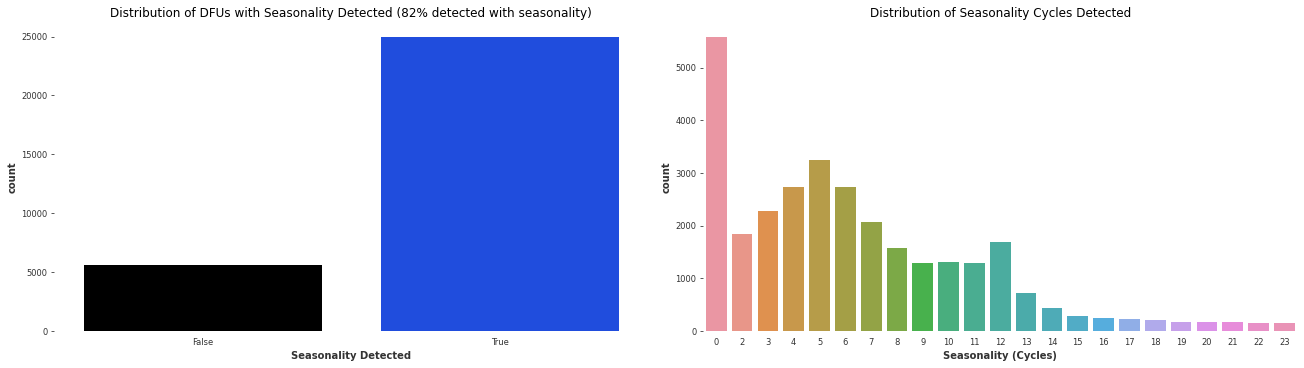

In [69]:
seasonality_detected_pct = (dfu_seasonality_df['Seasonality Detected'].value_counts(normalize=True) * 100).loc[True]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), constrained_layout=True)
sns.countplot(data=dfu_seasonality_df, x='Seasonality Detected', ax=axes[0])
sns.countplot(data=dfu_seasonality_df, x='Seasonality (Cycles)', ax=axes[1])
axes[0].set_title(f"Distribution of DFUs with Seasonality Detected ({seasonality_detected_pct:.0f}% detected with seasonality)")
axes[1].set_title("Distribution of Seasonality Cycles Detected")
axes[0].grid(False)
axes[1].grid(False)
fig.show()


# Data Pre-Processing

---

## (1) Mapping seasonality findings (dfu_seasonality_df) to original sales_df



In [72]:
processed_sales_df = sales_df.copy()
processed_sales_df = processed_sales_df.merge(dfu_seasonality_df.drop(columns=['Seasonality']), 
                                              on=['item_id', 'store_id'], how='left')

processed_sales_df


,item_id,store_id,yearmonth,sales,Seasonality Detected,Seasonality (Cycles)
0,FOODS_1_001,CA_1,2011-01-01,3,True,9
1,FOODS_1_001,CA_1,2011-02-01,40,True,9
2,FOODS_1_001,CA_1,2011-03-01,40,True,9
3,FOODS_1_001,CA_1,2011-04-01,23,True,9
4,FOODS_1_001,CA_1,2011-05-01,50,True,9
...,...,...,...,...,...,...
1951355,HOUSEHOLD_2_516,WI_3,2015-12-01,4,True,9
1951356,HOUSEHOLD_2_516,WI_3,2016-01-01,3,True,9
1951357,HOUSEHOLD_2_516,WI_3,2016-02-01,2,True,9
1951358,HOUSEHOLD_2_516,WI_3,2016-03-01,2,True,9


# Single-DFU Forecasts
---

## (0) Random Dataset (for testing purposes)

Text(0.5, 1.0, 'Item: HOUSEHOLD_2_428, Store: WI_1')

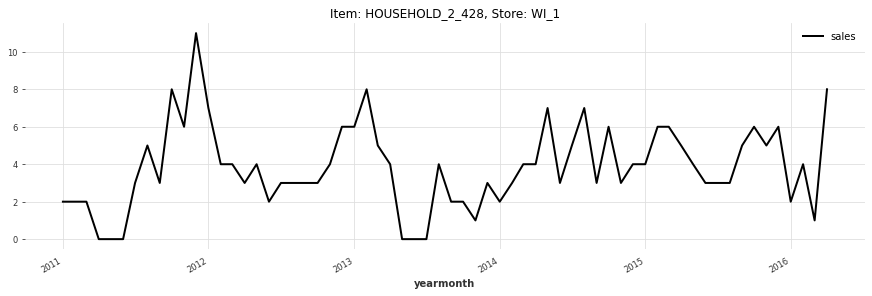

In [110]:
# Picking a random DFU for testing purposes
random_dfu = sales_df.sample(n=1)[['item_id', 'store_id']]

dfu_df = sales_df.loc[
    (sales_df['item_id'] == random_dfu['item_id'].values[0]) & 
    (sales_df['store_id'] == random_dfu['store_id'].values[0]), :
].copy()

dfu_ts = TimeSeries.from_dataframe(dfu_df, 'yearmonth', 'sales')

fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
dfu_ts.plot(ax=ax)
ax.set_title(f"Item: {random_dfu['item_id'].values[0]}, Store: {random_dfu['store_id'].values[0]}")

Text(0.5, 1.0, 'Item: HOUSEHOLD_2_428, Store: WI_1')

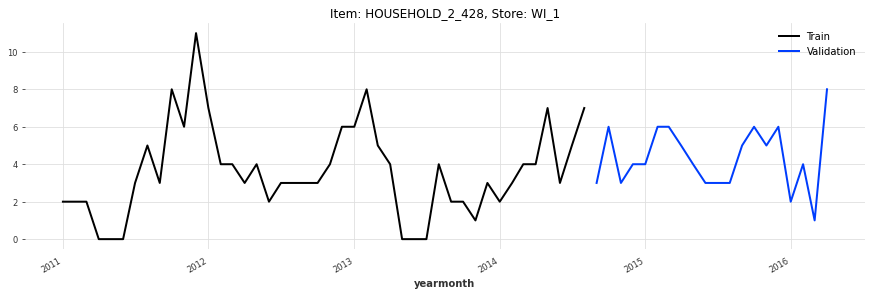

In [111]:
# Preparing a Train/Validation set based on the data available
train_end_idx = int(len(dfu_ts) * (1 - VALIDATION_SIZE))

train_ts = dfu_ts[:train_end_idx]
validation_ts = dfu_ts[train_end_idx:]

fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
train_ts.plot(ax=ax, label='Train')
validation_ts.plot(ax=ax, label='Validation')
ax.set_title(f"Item: {random_dfu['item_id'].values[0]}, Store: {random_dfu['store_id'].values[0]}")

### a) Single DFU Level Model (without covariates)

AutoARIMA

Text(0.5, 1.0, 'Item: HOUSEHOLD_2_428, Store: WI_1 \n MAE: 1.50 MAPE: 44.2%')

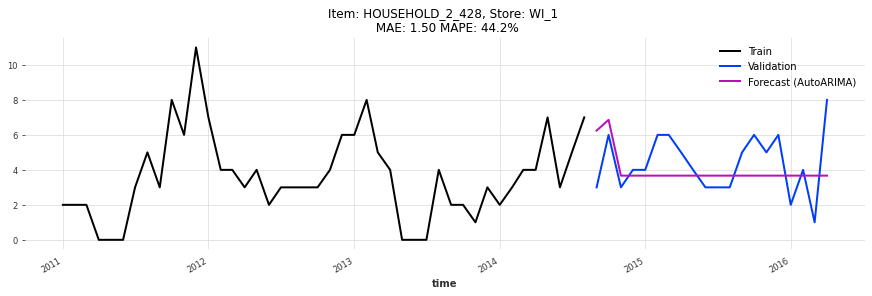

In [127]:
# Fitting model
auto_arima_model = AutoARIMA()
auto_arima_model.fit(train_ts)

# Forecasting
auto_arima_forecasts = auto_arima_model.predict(n=len(validation_ts))

# Plotting actual vs forecast & calculating metrics
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
train_ts.plot(ax=ax, label='Train')
validation_ts.plot(ax=ax, label='Validation')
auto_arima_forecasts.plot(ax=ax, label='Forecast (AutoARIMA)')
ax.set_title(f"Item: {random_dfu['item_id'].values[0]}, Store: {random_dfu['store_id'].values[0]} \
\n MAE: {mae(validation_ts, auto_arima_forecasts):.2f} MAPE: {mape(validation_ts, auto_arima_forecasts):.1f}%")

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

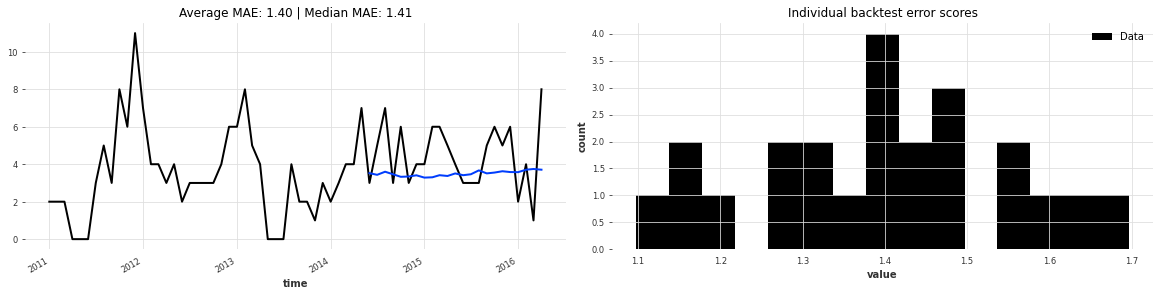

In [160]:
# Getting the summarised errors over backtesting (note: MAPE cannot be used if there are non-positive values, including 0)
average_error = auto_arima_model.backtest(dfu_ts, start=dfu_ts.time_index[auto_arima_model.min_train_series_length], 
                                          forecast_horizon=FORECAST_HORIZON, metric=mae, verbose=True)
median_error = auto_arima_model.backtest(dfu_ts, start=dfu_ts.time_index[auto_arima_model.min_train_series_length], 
                                         forecast_horizon=FORECAST_HORIZON, metric=mae, reduction=np.median, verbose=True)

# Distribution of raw errors from backtest
raw_errors = auto_arima_model.backtest(dfu_ts, start=dfu_ts.time_index[auto_arima_model.min_train_series_length],
                                       forecast_horizon=FORECAST_HORIZON, metric=mae, reduction=None, verbose=True)

# Trending of historical forecasts during backtesting (note that it only displays last data point of each forecast)
historical_forecast = auto_arima_model.historical_forecasts(
    dfu_ts, start=dfu_ts.time_index[auto_arima_model.min_train_series_length], forecast_horizon=FORECAST_HORIZON, 
    verbose=True
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), constrained_layout=True)
dfu_ts.plot(ax=axes[0], label='Original Data')
historical_forecast.plot(label='Backtest Forecast (AutoARIMA)', ax=axes[0])
axes[0].set_title(f"Average MAE: {average_error:.2f} | Median MAE: {median_error:.2f}")
plot_hist(raw_errors, bins=15, title="Individual backtest error scores", ax=axes[1])

In [155]:
# Complete historical forecasts (backtesting) for FAI & WTS calculation
historical_forecast_complete = auto_arima_model.historical_forecasts(
    dfu_ts, start=dfu_ts.time_index[auto_arima_model.min_train_series_length], forecast_horizon=FORECAST_HORIZON, 
    last_points_only=False, verbose=True
)

  0%|          | 0/23 [00:00<?, ?it/s]

In [164]:
fai_score, wts_score = fai_wts_dfu(dfu_ts, historical_forecast_complete, weighting_factors=FAI_WEIGHTING_FACTORS)
print(f"FAI: {fai_score * 100 :.2f}% | WTS: {wts_score:.3f}")

FAI: 64.42% | WTS: -0.110


## (1) No Seasonality DFUs

In [84]:
no_seasonality_sales_df = processed_sales_df[processed_sales_df['Seasonality Detected'] == False]

print(f"Number of DFUs with no seasonality detected: \
      {len(no_seasonality_sales_df[['item_id', 'store_id']].value_counts().index):,}")

Number of DFUs with no seasonality detected:       5,572
